Region Convergence Results (2000-2020)

In [18]:
import pandas as pd

df = pd.read_csv(r"C:\Users\glori\Downloads\QTM 350 Final Project\wdi_edu_filtered.csv")
df = df[~df['series'].str.contains('_')]

regions = [
    'East Asia & Pacific',
    'Latin America & Caribbean',
    'Middle East, North Africa, Afghanistan & Pakistan',
    'South Asia',
    'Sub-Saharan Africa'
]

edu_levels = ['primary', 'secondary', 'tertiary']

year_cols = [c for c in df.columns if "YR" in c]

df_long = df.melt(
    id_vars=['Country', 'series'],
    value_vars=year_cols,
    var_name='year',
    value_name='enrollment'
)

df_long['year'] = df_long['year'].str.replace('YR', '').astype(int)
df_long = df_long[(df_long['year'] >= 2000) & (df_long['year'] <= 2020)]

world = df_long[df_long['Country'] == "World"]

def compute_convergence(level):
    """
    Compute convergence for a given education level.
    Convergence is measured as reduction in the absolute gap to the world average:
        Convergence_Score = |gap2000| - |gap2020|
    Positive score = closer to world average (converging)
    Negative score = further from world average (diverging)
    """
    result = []

    for region in regions:
        region_df = df_long[(df_long['Country'] == region) & (df_long['series'] == level)]
        world_df = world[world['series'] == level]

        r2000 = region_df.loc[region_df['year'] == 2000, 'enrollment'].values[0]
        r2020 = region_df.loc[region_df['year'] == 2020, 'enrollment'].values[0]

        w2000 = world_df.loc[world_df['year'] == 2000, 'enrollment'].values[0]
        w2020 = world_df.loc[world_df['year'] == 2020, 'enrollment'].values[0]

        gap2000 = r2000 - w2000
        gap2020 = r2020 - w2020

        convergence_score = abs(gap2000) - abs(gap2020)

        result.append([
            region,
            level,
            gap2000,
            gap2020,
            convergence_score
        ])

    return pd.DataFrame(result, columns=[
        'Region', 'Level', 'Gap_2000', 'Gap_2020', 'Convergence_Score'
    ])

df_results = pd.concat([compute_convergence(l) for l in edu_levels])

df_results_sorted = df_results.sort_values(
    ["Level", "Convergence_Score"], ascending=False
)

df_results_sorted.to_csv(r"C:\Users\glori\Downloads\QTM 350 Final Project\convergenceresults.csv", index=False)

df_results_sorted


,Region,Level,Gap_2000,Gap_2020,Convergence_Score
3,South Asia,tertiary,-10.262691,-11.487999,-1.225308
2,"Middle East, North Africa, Afghanistan & Pakistan",tertiary,-5.927641,-11.402220,-5.474579
0,East Asia & Pacific,tertiary,-2.927410,12.944469,-10.017059
1,Latin America & Caribbean,tertiary,4.333410,15.161251,-10.827841
4,Sub-Saharan Africa,tertiary,-15.099781,-30.509499,-15.409718
3,South Asia,secondary,-11.963470,0.501328,11.462143
4,Sub-Saharan Africa,secondary,-34.036251,-31.802059,2.234192
1,Latin America & Caribbean,secondary,19.908268,20.610397,-0.702129
2,"Middle East, North Africa, Afghanistan & Pakistan",secondary,-9.257473,-15.780060,-6.522587
0,East Asia & Pacific,secondary,2.671848,13.392220,-10.720371


Enrollment Convergence Line Plots

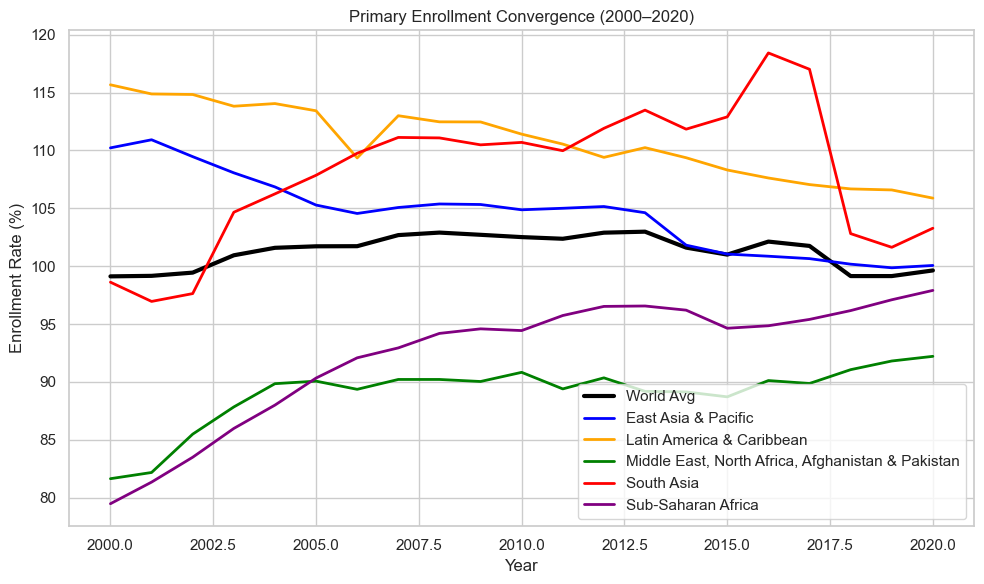

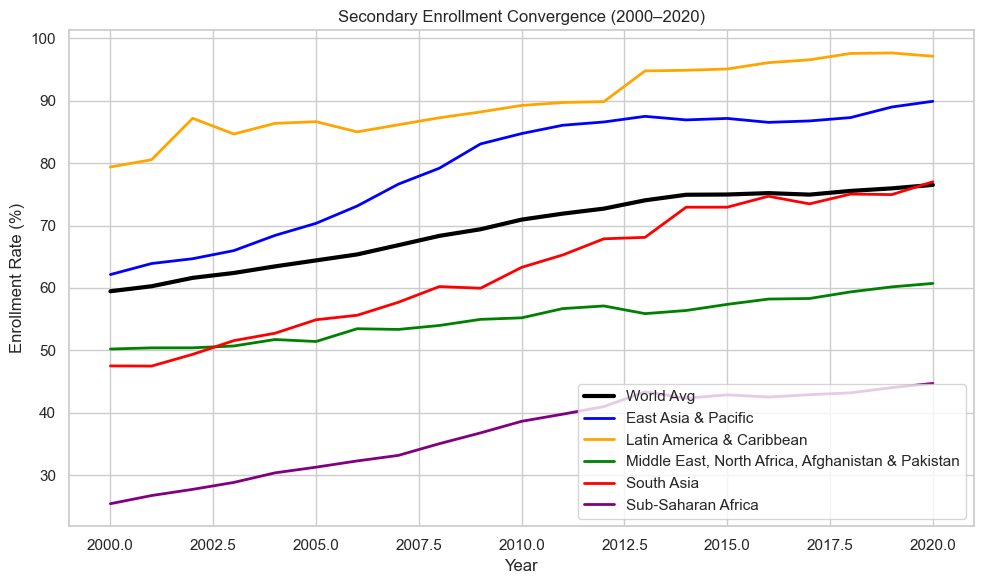

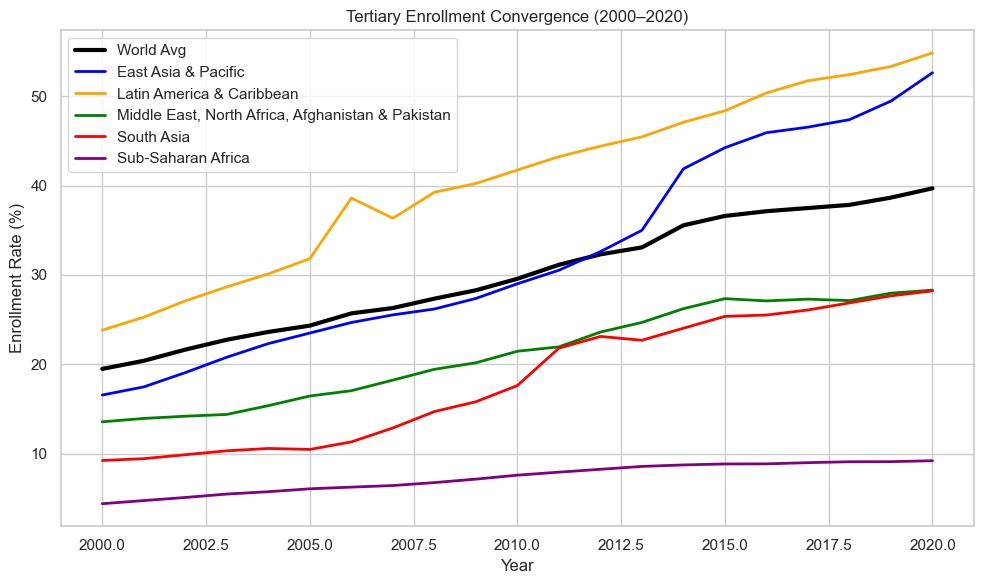

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Define colors for each region
region_colors = {
    'East Asia & Pacific': 'blue',         
    'Latin America & Caribbean': 'orange',    
    'Middle East, North Africa, Afghanistan & Pakistan': 'green',
    'South Asia': 'red',                   
    'Sub-Saharan Africa': 'purple',           
    'World Avg': 'black'                       
}

world_ts = world[['year','series','enrollment']]
region_ts = df_long[df_long['Country'].isin(regions)]

for level in edu_levels:
    plt.figure()

    # Plot world average
    w = world_ts[world_ts['series'] == level]
    plt.plot(w['year'], w['enrollment'], label='World Avg', linewidth=3, color=region_colors['World Avg'])
    for reg in regions:
        r = region_ts[(region_ts['Country'] == reg) & (region_ts['series'] == level)]
        plt.plot(r['year'], r['enrollment'], label=reg, color=region_colors[reg], linewidth=2)

    plt.title(f"{level.capitalize()} Enrollment Convergence (2000–2020)")
    plt.xlabel("Year")
    plt.ylabel("Enrollment Rate (%)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{level}_convergence_lines_colored.png")
    plt.show()


Enrollment Convergence Bar Plots

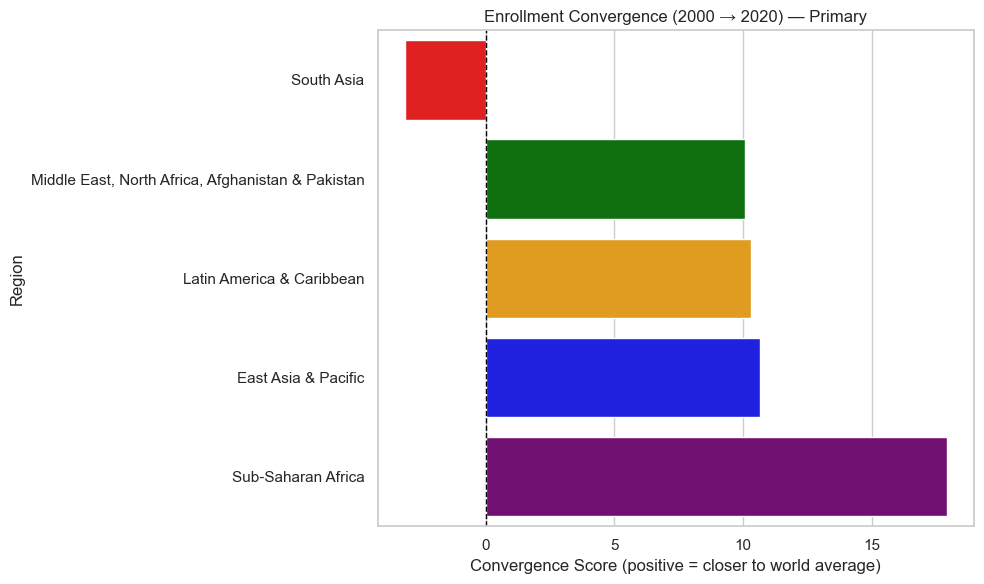

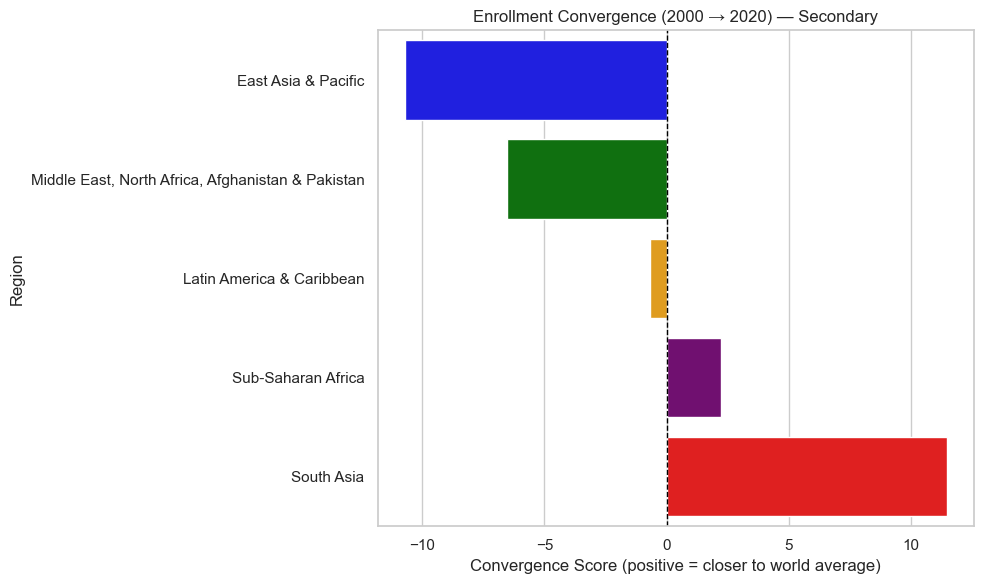

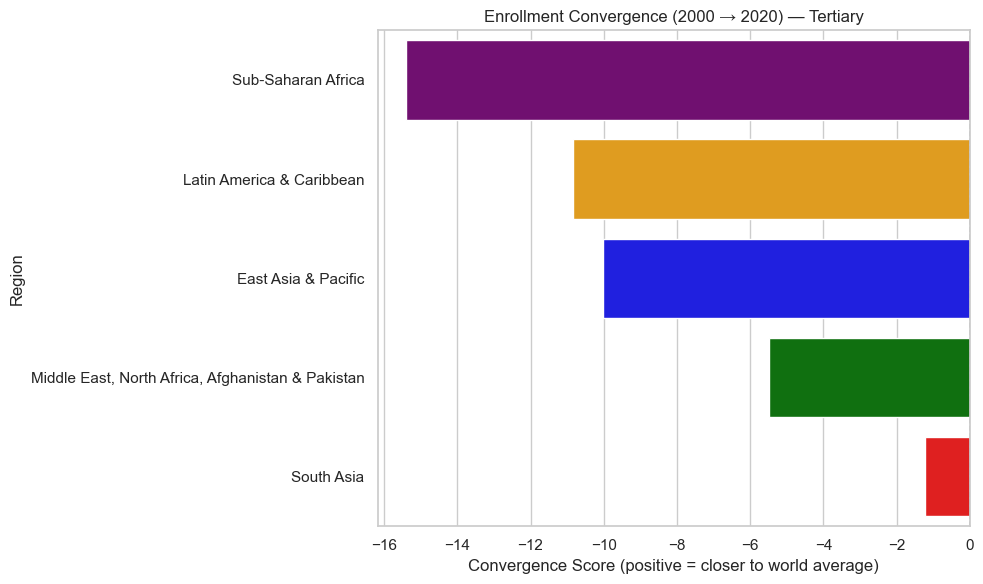

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
region_colors = {
    'East Asia & Pacific': 'blue',          
    'Latin America & Caribbean': 'orange',    
    'Middle East, North Africa, Afghanistan & Pakistan': 'green',  
    'South Asia': 'red',                   
    'Sub-Saharan Africa': 'purple'            
}

for level in edu_levels:
    plt.figure()
    subset = df_results_sorted[df_results_sorted['Level'] == level]
    subset = subset.sort_values('Convergence_Score', ascending=True)
    sns.barplot(
        data=subset,
        x='Convergence_Score',
        y='Region',
        palette={region: color for region, color in region_colors.items() if region in subset['Region'].values}
    )
    
    plt.title(f"Enrollment Convergence (2000 → 2020) — {level.capitalize()}")
    plt.xlabel("Convergence Score (positive = closer to world average)")
    plt.ylabel("Region")
    
    plt.axvline(0, color='black', linestyle='--', linewidth=1)
    
    plt.tight_layout()
    plt.savefig(f"{level}_convergence_barplot_colored.png")
    plt.show()


β-Convergence Regression Analysis

In [ ]:
import statsmodels.api as sm

print("\n==============================")
print("β-CONVERGENCE REGRESSION RESULTS")
print("==============================\n")

beta_results = []

for level in edu_levels:
    subset = df_results[df_results['Level'] == level].copy()
    
    y = subset['Convergence_Score']
    X = sm.add_constant(subset['Gap_2000'])
    
    model = sm.OLS(y, X).fit()
    
    print(f"\n--- {level.upper()} LEVEL β-CONVERGENCE ---")
    print(model.summary())
    
    beta_results.append({
        'Level': level,
        'Beta_Coefficient': model.params['Gap_2000'],
        'Beta_pvalue': model.pvalues['Gap_2000'],
        'Interpretation': (
            "Convergence (β < 0)"
            if model.params['Gap_2000'] < 0
            else "Divergence (β > 0)"
        )
    })

beta_df = pd.DataFrame(beta_results)

beta_df.to_csv(
    r"C:\Users\glori\Downloads\QTM 350 Final Project\beta_convergencesummary.csv",
    index=False
)

print("\nβ-convergence summary:")
print(beta_df.to_string(index=False))



β-CONVERGENCE REGRESSION RESULTS


--- PRIMARY LEVEL β-CONVERGENCE ---
                            OLS Regression Results                            
Dep. Variable:      Convergence_Score   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                 -0.219
Method:                 Least Squares   F-statistic:                    0.2806
Date:                Mon, 08 Dec 2025   Prob (F-statistic):              0.633
Time:                        21:25:01   Log-Likelihood:                -16.470
No. Observations:                   5   AIC:                             36.94
Df Residuals:                       3   BIC:                             36.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

c:\Users\glori\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\glori\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
c:\Users\glori\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
